In [2]:
# -*- coding: utf-8 -*-
#两个隐含层的lstm
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
#import tensorflow as tf#tensorflow1.x环境就用这个
import tensorflow.compat.v1 as tf#tensorflow2.x环境就用这两句
tf.disable_v2_behavior()

import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import savemat
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 0  ,train loss  0.12741742541848283  ,valid loss:  0.022797812
epoch: 1  ,train loss  0.007321031349185373  ,valid loss:  0.033558756
epoch: 2  ,train loss  0.0033391362718952406  ,valid loss:  0.03338041
epoch: 3  ,train loss  0.002453257359804645  ,valid loss:  0.016053108
epoch: 4  ,train loss  0.0019215396220510403  ,valid loss:  0.017108923
epoch: 5  ,train loss  0.0018372457463204136  ,valid loss:  0.0112510845
epoch: 6  ,train los

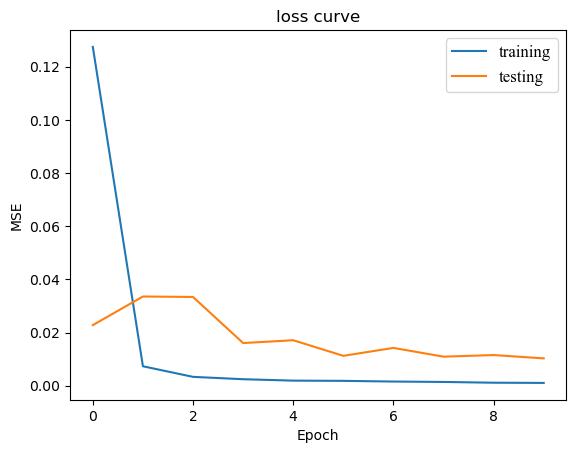

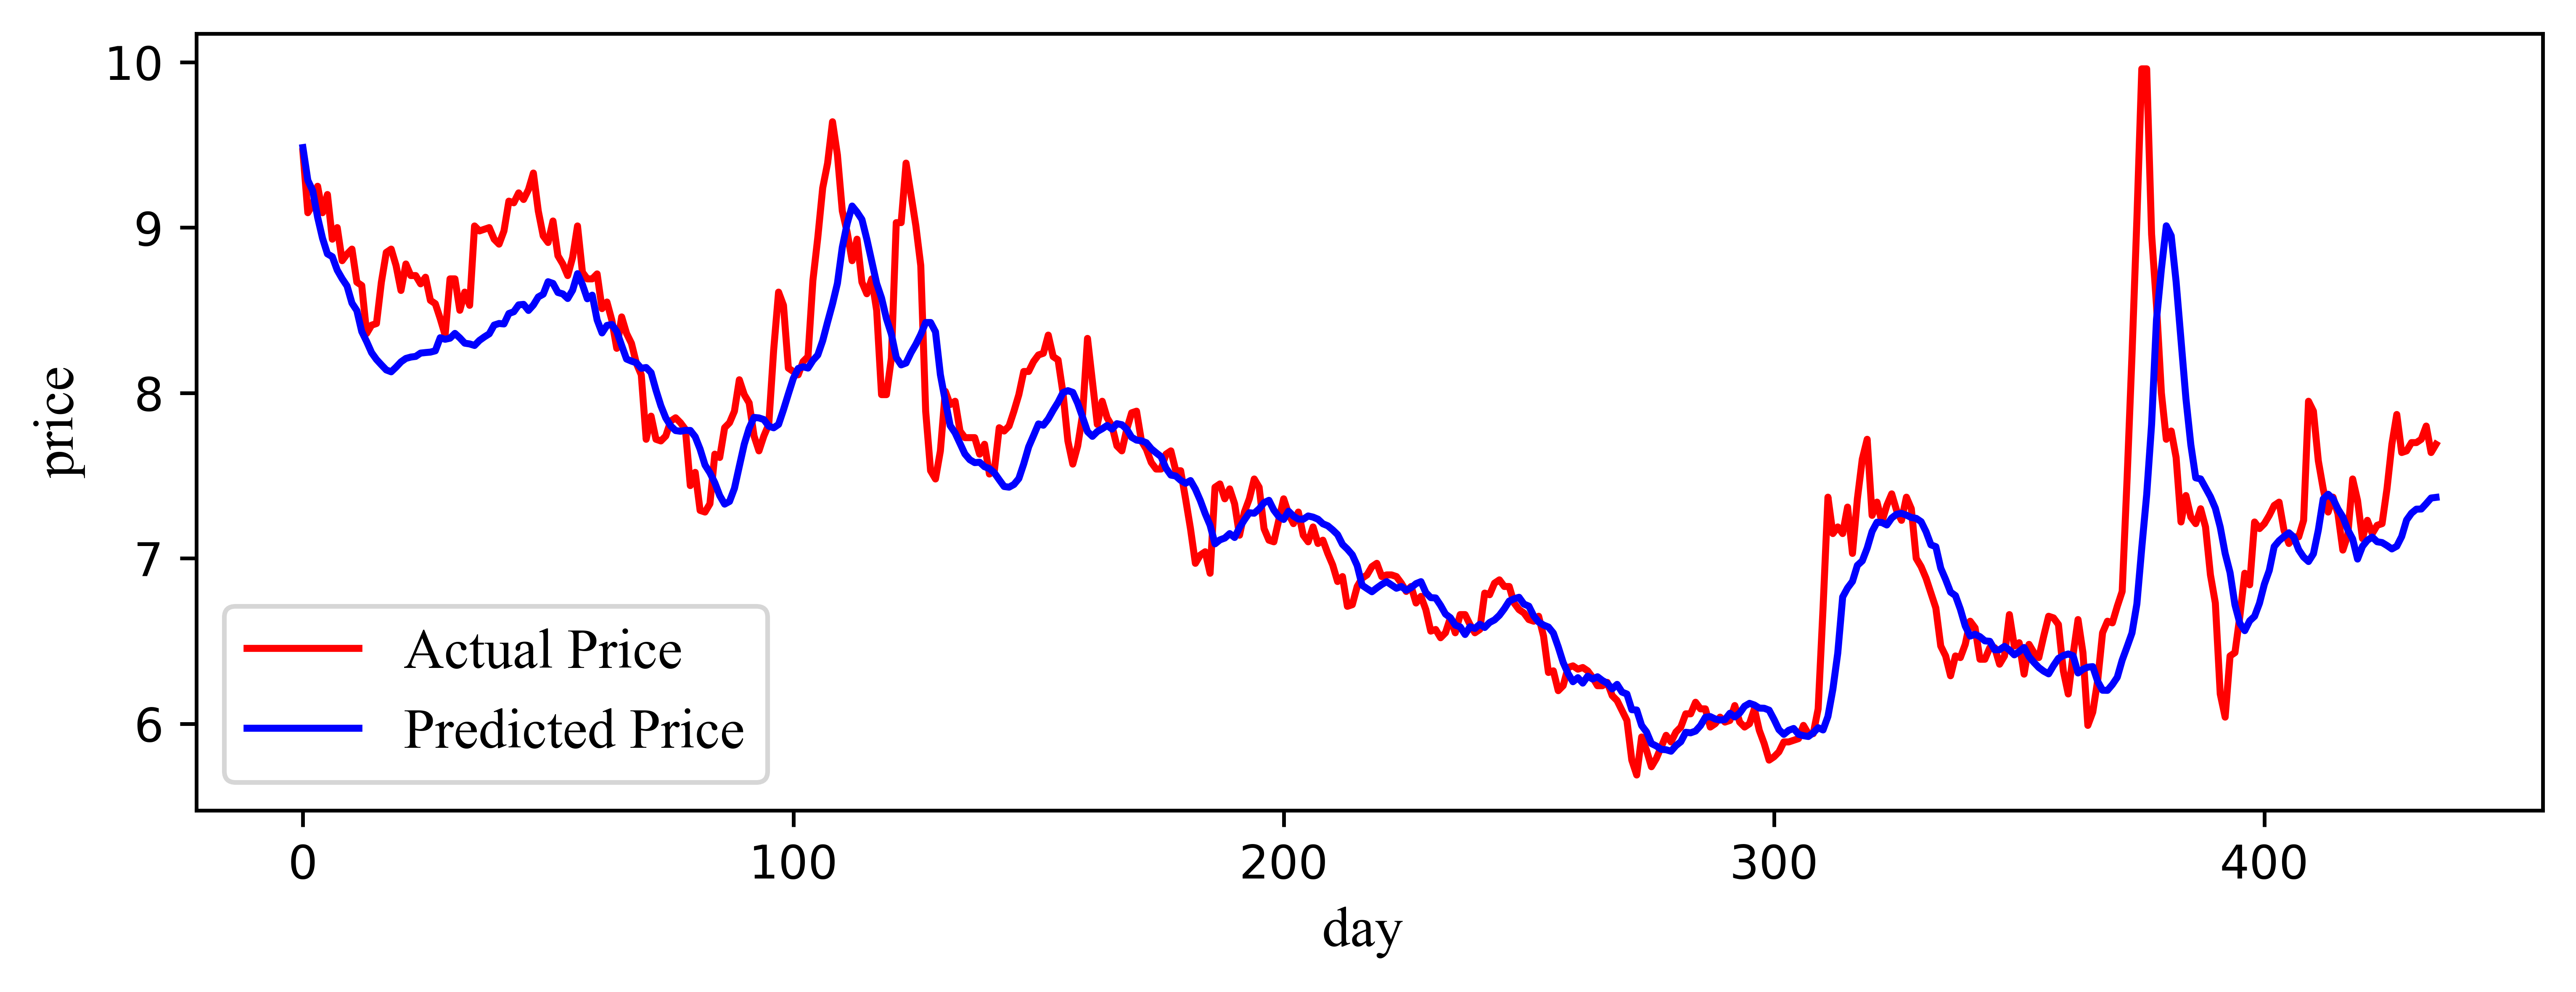

LSTM测试集的mape: 0.036460082419365714  rmse: 0.43322848971529654  mae: 0.2835469625193045  R2: 0.8006008595617401  tic: 0.02908495691673078


In [3]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)
# In[] 加载数据
xlsfile=pd.read_excel('数据集/002424a.xlsx').iloc[0:,1:]# 前两列的日期不作为特征之一
data=np.array(xlsfile)
data

from model import split_data
time_steps=30
in_,out_=split_data(data,time_steps)
n=range(in_.shape[0])
m=-436#最后两天测试
train_data = in_[n[0:m],]
test_data = in_[n[m:],]
train_label = out_[n[0:m],]
test_label = out_[n[m:],]

# 归一化
ss_X=MinMaxScaler(feature_range=(0,1)).fit(train_data)
ss_y=MinMaxScaler(feature_range=(0,1)).fit(train_label)
train_data = ss_X.transform(train_data)
train_label = ss_y.transform(train_label)
ss_X=MinMaxScaler(feature_range=(0,1)).fit(test_data)
ss_y=MinMaxScaler(feature_range=(0,1)).fit(test_label)
test_data = ss_X.transform(test_data)
test_label = ss_y.transform(test_label)

# In[]定义超参数

alpha = 0.01# 学习率
num_epochs = 10#迭代次数
hidden_nodes0 =100#第一隐含层神经元
hidden_nodes = 20#第二隐含层神经元
batch_size = 16# batchsize
input_features = train_data.shape[1]
output_class = train_label.shape[1]# 34输入 24输出

# placeholder
X = tf.placeholder("float", [None, input_features])
Y = tf.placeholder("float", [None, output_class])

# 定义一个隐层的神经网络
def RNN(x):
    x = tf.reshape(x , [-1, 1,input_features])
    # 定义输出层权重
    weights = {'out': tf.Variable(tf.random_normal([hidden_nodes, output_class]))}
    biases = {'out': tf.Variable(tf.random_normal([output_class]))}
    lstm_cell0 = tf.nn.rnn_cell.LSTMCell(hidden_nodes0)    
    lstm_cell = tf.nn.rnn_cell.LSTMCell(hidden_nodes)
    lstm_cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell0,lstm_cell])
    #初始化
    init_state = lstm_cell.zero_state(tf.shape(x)[0], dtype=tf.float32)
    outputs, _ = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32, initial_state=init_state)
    
    output_sequence = tf.matmul(tf.reshape(outputs, [-1, hidden_nodes]), weights['out']) + biases['out']
    return tf.reshape(output_sequence, [-1, output_class])

# In[] 初始化
logits = RNN(X)
loss = tf.losses.mean_squared_error(predictions = logits, labels = Y)
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
                alpha,
                global_step,
                num_epochs, 0.99,
                staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon = 1e-10).minimize(loss,global_step=global_step)
init = tf.global_variables_initializer()

# In[]训练
train = []
valid=[]
with tf.Session() as sess:
    sess.run(init)
    N = train_data.shape[0]
    for epoch in range(num_epochs):
        total_batch = int(math.ceil(N / batch_size))
        indices = np.arange(N)
        np.random.shuffle(indices)
        avg_loss = 0
        # 迭代训练，顺便计算训练集loss
        for i in range(total_batch):
            rand_index = indices[batch_size*i:batch_size*(i+1)]
            x = train_data[rand_index]
            y = train_label[rand_index]
            _, cost = sess.run([optimizer, loss],
                                feed_dict={X: x, Y: y})
            avg_loss += cost / total_batch
            
        # 计算测试集loss
        valid_data=test_data
        valid_y = test_label
        valid_loss = sess.run(loss, feed_dict={X: valid_data, Y: valid_y})
        
        train.append(avg_loss)
        valid.append(valid_loss)
        print('epoch:',epoch,' ,train loss ',avg_loss,' ,valid loss: ',valid_loss)

    #计算训练集与测试集的预测值
    train_pred = sess.run(logits, feed_dict={X: train_data})
    test_pred = sess.run(logits, feed_dict={X: test_data})
# 对测试结果进行反归一化
test_pred = ss_y.inverse_transform(np.array(test_pred.reshape(-1,1)))
test_label = ss_y.inverse_transform(test_label)
# In[] 画loss曲线
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 12,
}
g = plt.figure()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.plot( train, label='training')
plt.plot( valid, label='testing')
plt.title('loss curve')
plt.legend(prop = font1)

# In[] 
# 画出测试集的值
test_label=test_label.reshape(-1,1)
test_pred=test_pred.reshape(-1,1)
plt.figure(figsize=(9, 3), dpi=800)
plt.plot(test_label, c='r', label='Actual Price')
plt.plot(test_pred, c='b',label='Predicted Price')
plt.xlabel('day ',fontproperties = 'Times New Roman', fontsize=12)
plt.ylabel('price',fontproperties = 'Times New Roman', fontsize=12)
plt.legend(prop = font1)
plt.savefig('figure/002424-MS-LSTM预测结果.jpg')
plt.show()

savemat('果实/002424MS-lstm_result.mat',{'true':test_label,'pred':test_pred})
# In[]计算各种指标
# mape
test_mape=np.mean(np.abs((test_pred-test_label)/test_label))
# rmse
test_rmse=np.sqrt(np.mean(np.square(test_pred-test_label)))
# mae
test_mae=np.mean(np.abs(test_pred-test_label))
# R2
test_r2=r2_score(test_label,test_pred)
# TIC
test_tic=np.sqrt(np.mean(np.square(test_pred-test_label)))/(np.sqrt(np.mean(np.square(test_label)))+np.sqrt(np.mean(np.square(test_pred))))


print('LSTM测试集的mape:',test_mape,' rmse:',test_rmse,' mae:',test_mae,' R2:',test_r2,' tic:',test_tic)
